In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

In [4]:
xs = np.arange(-5,5,0.25)

In [5]:
print(xs)

[-5.   -4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25
 -2.   -1.75 -1.5  -1.25 -1.   -0.75 -0.5  -0.25  0.    0.25  0.5   0.75
  1.    1.25  1.5   1.75  2.    2.25  2.5   2.75  3.    3.25  3.5   3.75
  4.    4.25  4.5   4.75]


In [6]:
 ys = f(xs)
print(ys)

[100.      91.6875  83.75    76.1875  69.      62.1875  55.75    49.6875
  44.      38.6875  33.75    29.1875  25.      21.1875  17.75    14.6875
  12.       9.6875   7.75     6.1875   5.       4.1875   3.75     3.6875
   4.       4.6875   5.75     7.1875   9.      11.1875  13.75    16.6875
  20.      23.6875  27.75    32.1875  37.      42.1875  47.75    53.6875]


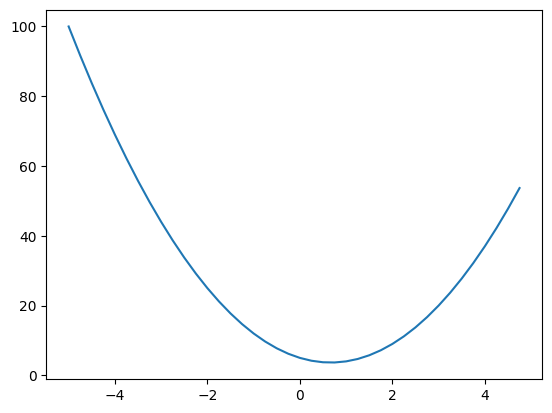

In [7]:
plt.plot(xs,ys)

In [8]:
h=0.00009
a = 3
(f(a+h)-f(a))/h

14.000270000025239

In [9]:
class Value:
    def __init__(self,data, _children=(),_op="",label=""):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self):
        return f"Value(data={self.data} label={self.label})"

    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other) # so that i can add a numerical also
        out = Value(self.data + other.data,(self,other),"+")

        def _backward():
            self.grad += 1.0 * out.grad # for multiple edges (same Value contributing multiple places) the grad should get accumulate
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __neg__(self):
        return self * -1
        
    def __sub__(self,other):
        return self + (-other)

    def __rsub__(self,other):
        return other + (-self)
        
    def __radd__(self,other): #so that we can call 1 + a(value object) it's a fallback
        return self + other
        
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other),"*")
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out

    def __pow__(self,other):
        assert isinstance(other,(int,float)),"only supporting int/float powers for now"
        out = Value(self.data**other,(self,), f'**{other}')

        def _backward():
            self.grad += ((other * (self.data)**(other-1))) * (out.grad)
            
        out._backward = _backward
        return out
        
    def __rmul__(self,other): #so that we can call 1 * a(value object)
        return self*other
        
    def __truediv__(self,other): # self / other
        return self * other**-1

        
    def tanh(self):
        n = self.data
        x = (math.exp(2*n) - 1) / (math.exp(2*n) + 1)
        out = Value(x,(self,),"tanh")
        def _backward():
            self.grad += ((1 - x**2) * (out.grad))
            
        out._backward = _backward
        return out

    def backward(self):
        topo=[]
        visited=set()
        def build_topo(node):
            if node not in visited:
                visited.add(node)
                for child in node._prev:
                    build_topo(child)
                topo.append(node)
        
        
        build_topo(self)
        self.grad=1.0
        for node in reversed(topo):
            node._backward()

    def exp(self):
        x = self.data
        out = Value(math.exp(x),(self,),"exp")
        def _backward():
            self.grad += ((math.exp(x)) * (out.grad))
            
        out._backward = _backward
        return out

# a = Value(2.0,label="a")
# b = Value(-3.0, label="b")
# c = Value(10.0, label="c")
# e = a * b ; e.label="e"
# d= e + c; d.label="d"
# f = Value(-2.0,label="f")
# L = d * f; L.label="L"

In [10]:
a = Value(4.0,label="a")
b = Value(2.0,label="b")

a / b

Value(data=2.0 label=)

In [11]:
# !pip install graphviz

In [12]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root):
 
    dot = Digraph(format="svg", graph_attr={'rankdir': 'LR'}) # LR = Left to Right
    nodes, edges = trace(root)
    
    for n in nodes:
        uid = str(id(n))
        dot.node(name=uid, label = "{ %s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape='record')

        if n._op:
            dot.node(name=uid + n._op, label=n._op)
            dot.edge(uid + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [13]:
# draw_dot(o)

### time to fill up the grad and do back propagation manualy

In [14]:
# for L node
# derivative of L w.r.t L (if I change L by a tiny amount of h how much does L change)
# dL/ dL = 1 

In [77]:
# L.grad = 1.0

In [ ]:
# now for the node d and f
# dL/dd = ? and dL/df ?
# L = d*f =
#  dL/ dd = f = -2.0 and dL/df = d = 4.0
d.grad = -2.0
f.grad = 4.0

In [ ]:
# Now for the node c and e
# d = c + e
# dL/dc and dL/de
# using chain rule by looking at the equation 
# dL/dc = dL/dd x dd/dc (dL/dd = -2.0 from previous step)
#       = -2.0 x d/dc (c + e) = -2.0 x 1 = -2.0
# dL/dc = 12.0
# dL/de = dL/dd x dd/de = -2.0 x 1 = -2.0 
c.grad = -2.0
e.grad = -2.0

In [ ]:
# Now calculating for a , b
# a * b = e
# dL/da = ? and dL/db = ?
# again using a chain rule now
# by looking at the equvalent equation
# dL/da = dL/de * de/da = -2.0 * d/da (ab) = -2.0 * b = -2.0 * -3.0 = 6
# dL/db = dL/de * de/db = -2.0 * d/db (ab) = -2.0 * a = -2.0 * 2.0 = -4.0
a.grad = 6.0
b.grad = -4.0

In [ ]:
# Test the derivative numericals manually

def lol():

    h= 0.001
    
    a = Value(2.0,label="a")
    b = Value(-3.0, label="b")
    c = Value(10.0, label="c")
    e = a * b ; e.label="e"
    d= e + c; d.label="d"
    f = Value(-2.0,label="f")
    L = d * f; L.label="L"
    L1 = L.data

    a = Value(2.0,label="a")
    b = Value(-3.0 + h, label="b")
    c = Value(10.0, label="c")
    e = a * b ; e.label="e"
    d= e + c; d.label="d"
    f = Value(-2.0,label="f")
    L = d * f; L.label="L"
    L2 = L.data

    print((L2 - L1) / h)

lol()

In [ ]:
# print(np.tanh(-19))

In [ ]:
plt.plot(np.arange(-5,5,0.2),np.tanh(np.arange(-5,5,0.2)))
plt.grid()

## Now I am gonna implement a small nueron , and use tanh as a squash func
![nueron](https://cs231n.github.io/assets/nn1/neuron_model.jpeg)

In [ ]:
draw_dot(L)

In [ ]:
# add grad now
o.grad = 1.0 #derivative of o w.r.t o is 1

# o= tanh(n) => d (tanh(x))/ dx = 1- tanh^2(x) => d (tanh(n)) / dn => 1-tanh^2(n) => 1- o^2 (as o = tanh(n))
n.grad =  1- (o.data)**2 #0.5

b.grad = 0.5 # do/db = do/dn x dn/db = 0.5 x 1

x1w1x2w2.grad = 0.5
x1w1.grad = 0.5 * 1.0
x2w2.grad = 0.5 * 1.0
x1.grad = 0.5 * w1.data
w1.grad = 0.5 * x1.data
x2.grad = 0.5 * w2.data
w2.grad = 0.5 * x2.data

### Now try to implement this grad automatically observing the behaviour of plus and mul and tanh. 
#### in addtion it will be 1 * (forward local grad)
### in mul it will be other.data x (forward local grad)

In [ ]:
# Alternative way of automatically adding grad
o.grad = 1.0 # base condition
o._backward()
n._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

### Now Try to automate this using topological sort so that we dont have to call backward function manually

In [ ]:
# inputs variables
x1 = Value(2.0,label="x1")
x2 = Value(0,label="x2")

# weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

# bias
b = Value(6.8813735870195432,label="b")
x1w1=x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2;x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label="n"

o = n.tanh();o.label="o"

# ------- Now update the o as we have multiple math opearation in value class
# e = (2*n).exp(); e.label="e"
# o = (e+1) / (e-1)
# o.label = "o"
o.backward()

In [ ]:
draw_dot(o)

In [ ]:
# Topological sort
# topo=[]
# visited=set()
# def build_topo(node):
#     if node not in visited:
#         visited.add(node)
#         for child in node._prev:
#             build_topo(child)
#         topo.append(node)


# build_topo(o)
# o.grad=1.0
# for node in reversed(topo):
#     node._backward()


In [ ]:
o.backward()

In [ ]:
a = Value(3.0,label="a")
1 + a

In [ ]:
a = Value(4.0,label="a")
2.6 * a

In [ ]:
# inputs variables
x1 = Value(2.0,label="x1")
x2 = Value(0,label="x2")

# weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

# bias
b = Value(6.8813735870195432,label="b")
x1w1=x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2;x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label="n"

o = n.tanh();o.label="o"

o.backward()
draw_dot(o)

In [ ]:
# inputs variables
x1 = Value(2.0,label="x1")
x2 = Value(0,label="x2")

# weights 
w1 = Value(-3.0,label="w1")
w2 = Value(1.0,label="w2")

# bias
b = Value(6.8813735870195432,label="b")
x1w1=x1 * w1; x1w1.label = "x1w1"
x2w2 = x2 * w2;x2w2.label = "x2w2"
x1w1x2w2 = x1w1 + x2w2 ; x1w1x2w2.label = "x1w1 + x2w2"

n = x1w1x2w2 + b; n.label="n"

# o = n.tanh();o.label="o"

# ------- Now update the o as we have multiple math opearation in value class
e = (2*n).exp(); e.label="e"
o = (e-1) / (e+1)
o.label = "o"
o.backward()
draw_dot(o)

### Defined Neuron

## Now I am gonna implement a nueron network , and use tanh as a squash func
![nueron network](https://cs231n.github.io/assets/nn1/neural_net2.jpeg)

In [80]:
class Neuron:
    def __init__(self,nin): #nin = number of inputs in the nueron
        # here assingning the weights if the inputs
        self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
        self.b =Value(random.uniform(-1,1))

    def __call__(self,x):
            # x*w + b
            
            act = sum(xi*wi for xi,wi in zip(x,self.w)) + self.b
            out = act.tanh()
            
            return out
    def parameters(self):
        return self.w + [self.b]
# n = Neuron(2)
x = [2.0,3.0]
# n(x) # This will invoke the __call__ method

class Layer:
    def __init__(self,nin,nout):
        # print("Layer: initialised with ",nin,nout)
        self.neurons =[Neuron(nin) for _ in range(nout)] #This will be like a layer for example here 3 neurons with 2 inputs and 1 output

    def __call__(self,x):
        outs = [n(x)for n in self.neurons]
        return outs[0] if len(outs)==1 else outs

    def parameters(self):
        params = []
        for nueron in self.neurons:
            params.extend(nueron.parameters())
        return params
# n = Layer(2,3) #2,3 means we have total 3 neurons in a layer and each nueron has 2 input and 1 output
# n(x)

class MLP: #Multilayer Perceptron (MLP)
    def __init__(self,nin,nouts):
        sz = [nin]+nouts
        self.layers =[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self,x):
        for layer in self.layers:
            # print("MLP: Layer called with input",x)
            x = layer(x)
        return x
    def parameters(self):
        params = []
        for layer in self.layers:
            for p in layer.parameters():
                params.append(p)
        return params

x = [2.0,3.0,-1.0]
n = MLP(3,[4,4,1]) #This is trying to simulate the above MLP in diagram considering 
# first layer having 3 (consider it as a inputs) and rest defined number of neurons needs to be present at each layer stating 
n(x)

Value(data=0.8927930063628413 label=)

In [ ]:
draw_dot(n(x))

In [19]:
# sample input
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] #desired targets


In [74]:
ypred = [n(x) for x in xs] #currently the output we are getting
ypred

MLP: Layer called with input [2.0, 3.0, -1.0]
MLP: Layer called with input [Value(data=-0.9008236202884149 label=), Value(data=0.9995140087597716 label=), Value(data=-0.9950213896211352 label=), Value(data=0.9999661488438927 label=)]
MLP: Layer called with input [Value(data=0.22416780310724227 label=), Value(data=-0.7657957584736903 label=), Value(data=-0.962774259284375 label=), Value(data=0.940706513232283 label=)]
MLP: Layer called with input [3.0, -1.0, 0.5]
MLP: Layer called with input [Value(data=0.9959933807500115 label=), Value(data=-0.919916064718418 label=), Value(data=-0.722287380651278 label=), Value(data=0.9970516329432914 label=)]
MLP: Layer called with input [Value(data=0.9712362747107609 label=), Value(data=0.9654785688881515 label=), Value(data=0.8864049691678334 label=), Value(data=-0.9995572359406973 label=)]
MLP: Layer called with input [0.5, 1.0, 1.0]
MLP: Layer called with input [Value(data=0.9835150464702078 label=), Value(data=-0.647196804349521 label=), Value(d

[Value(data=0.9916299758014671 label=),
 Value(data=-0.9994584618317435 label=),
 Value(data=-0.9994315982467912 label=),
 Value(data=0.9859949988186446 label=)]

### Calculating the loss
### we are going to implement mean sqare error loss

In [75]:
loss = [(ygt-yout)**2 for ygt,yout in zip(ys,ypred)] #This is going to calculate loss for each 4 inputs
print(loss)
loss = sum(loss)
print(loss)

[Value(data=7.005730508402705e-05 label=), Value(data=2.932635876786355e-07 label=), Value(data=3.2308055305086576e-07 label=), Value(data=0.00019614005808976594 label=)]
Value(data=0.00026681370731452246 label=)


### If we are way off the loss would be high , so we want low loss

### Now lets sum the loss and our only target will be to reduce the overall loss (loss minimum is 0 and greater it is our NN is worst predicting)

In [22]:
n.layers[0].neurons[0].b

In [76]:
# before calling the backword pass we need to reset the grad for that parameters that we going to update
    # this is because gard is getting accumulated , so we need to flush the grad and reset it to 1 befor calculating
    # the backword pass which is going add the update grads in the nodes
    # other wise old grad stays and new grad is getting accumulated on top if it
for p in n.parameters():
    p.grad = 0.0
loss.backward()

### If grad is +ve means if we increse the value of this node the loss will also increase

In [ ]:
draw_dot(loss)

### Added paramerts details in the NN classes . Because as we be reducing the lossing by nudjing the input . Now the X values are inputs which are fixed we can adjust the weights and bias in that case

In [47]:
n.parameters()

[Value(data=0.23869878725569593 label=),
 Value(data=-0.5366467953674388 label=),
 Value(data=0.8602558171287449 label=),
 Value(data=0.27561452011659066 label=),
 Value(data=-0.07106458165702023 label=),
 Value(data=0.6819712644897198 label=),
 Value(data=-0.7616016463638879 label=),
 Value(data=-0.19825072110359157 label=),
 Value(data=-0.3370367676146474 label=),
 Value(data=-0.39505167858933077 label=),
 Value(data=0.5295239848955053 label=),
 Value(data=-0.7682514043919179 label=),
 Value(data=0.5619972795672841 label=),
 Value(data=0.0863271298432089 label=),
 Value(data=-0.25110579288052376 label=),
 Value(data=1.0699250464121801 label=),
 Value(data=0.9099963686947353 label=),
 Value(data=0.6988623230212508 label=),
 Value(data=0.07477985707634158 label=),
 Value(data=0.423982165253425 label=),
 Value(data=-0.6732284443254578 label=),
 Value(data=0.9190863953076774 label=),
 Value(data=0.14088649949865806 label=),
 Value(data=-0.4697918875027235 label=),
 Value(data=-0.29258132

In [31]:
len(n.parameters())

41

### Now As we have the parameter details of our NN Now to improve our NN prediction we will try to adjust the parameter details by studying the grad of a parameter. If the grad is -ve means increasing that data will decrease the loss and for +ve decreasing thar velue will decrease the loss value

### will try to nudje this by a vary small factor , will update the data of params, forward pass (the prediction), backword pass , check loss, check output , repeat until get get our desired output.

### we change the data by a very large factor then we might missed or jump from a actual point so we will do it by a small factor

In [73]:
for p in n.parameters():
    p.data += -0.01 * p.grad
    #0.01 is tge factor we are using and multiplying with it's grad . If grad is -ve the we will increase the p.data
    # value , if grad is +ve the we will decrease the p.data value to improve/reduce the loss

### Just a update :- after repeatating doing (alomost 10-15 times) the will update the data of params (above step), forward pass (the prediction), backword pass of loss, check loss, check output , repeat until get get our desired output.

### I am getting

### sum_loss = Value(data=0.00026681370731452246 label=)
### output = [Value(data=0.9916299758014671 label=),
### Value(data=-0.9994584618317435 label=),
### Value(data=-0.9994315982467912 label=),
### Value(data=0.9859949988186446 label=)]

### which is alomost matiching out desired output [1.0,-1.0,-1.0,1.0]



### Below I am accumulating all the steps in one

In [ ]:
# Just accumulating this septs together also
n = MLP(3,[4,4,1]) # nn
# inputs
xs = [
    [2.0,3.0,-1.0],
    [3.0,-1.0,0.5],
    [0.5,1.0,1.0],
    [1.0,1.0,-1.0]
]
ys = [1.0,-1.0,-1.0,1.0] #desired targets
ypred = []

In [123]:

for step in range(20):

    # forward pass
    ypred = [n(x) for x in xs]
    loss = sum([(ygt-yout)**2 for ygt,yout in zip(ys,ypred)])

    # before calling the backword pass we need to reset the grad for that parameters that we going to update
    # this is because gard is getting accumulated , so we need to flush the grad and reset it to 1 befor calculating
    # the backword pass which is going add the update grads in the nodes
    # other wise old grad stays and new grad is getting accumulated on top if it
    for p in n.parameters():
        p.grad = 0.0
    # backword pass
    loss.backward()

    # update the params
    for p in n.parameters():
        p.data += -0.05 * p.grad

    # edge case for the last round
    if step == 19:
        # forward pass
        ypred = [n(x) for x in xs]
        loss = sum([(ygt-yout)**2 for ygt,yout in zip(ys,ypred)])
    
        # backword pass
        loss.backward()
        
    print(step, loss)

0 Value(data=0.00010971884783576814 label=)
1 Value(data=0.00010914930111831838 label=)
2 Value(data=0.00010858557985609301 label=)
3 Value(data=0.00010802759547124167 label=)
4 Value(data=0.00010747526116912858 label=)
5 Value(data=0.00010692849189374205 label=)
6 Value(data=0.00010638720428442324 label=)
7 Value(data=0.00010585131663389146 label=)
8 Value(data=0.00010532074884748572 label=)
9 Value(data=0.00010479542240363723 label=)
10 Value(data=0.00010427526031547518 label=)
11 Value(data=0.0001037601870935574 label=)
12 Value(data=0.00010325012870967694 label=)
13 Value(data=0.0001027450125617264 label=)
14 Value(data=0.00010224476743956283 label=)
15 Value(data=0.00010174932349182495 label=)
16 Value(data=0.00010125861219374132 label=)
17 Value(data=0.00010077256631580677 label=)
18 Value(data=0.00010029111989336536 label=)
19 Value(data=9.934176770393891e-05 label=)


In [124]:
ypred

[Value(data=0.995526843332068 label=),
 Value(data=-0.9967037769414128 label=),
 Value(data=-0.9943248049644591 label=),
 Value(data=0.9939783962281894 label=)]